# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.training import Model, triplet_mining, eval_fn

## Plotting datasets

### Initialise datasets

In [2]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Plotting

#### Training data

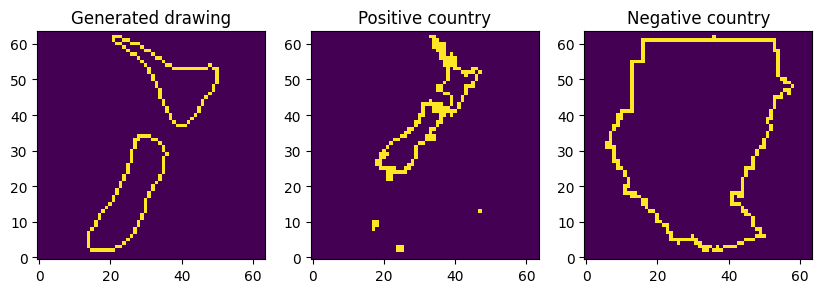

In [30]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

In [31]:
from countryguess.utils import poly_to_img

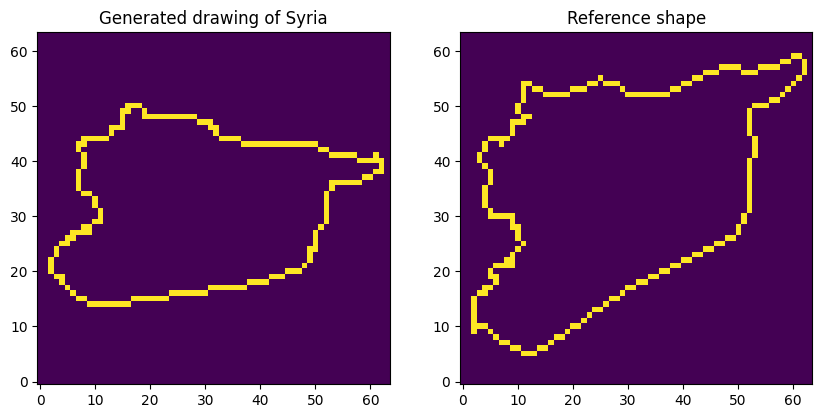

In [51]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

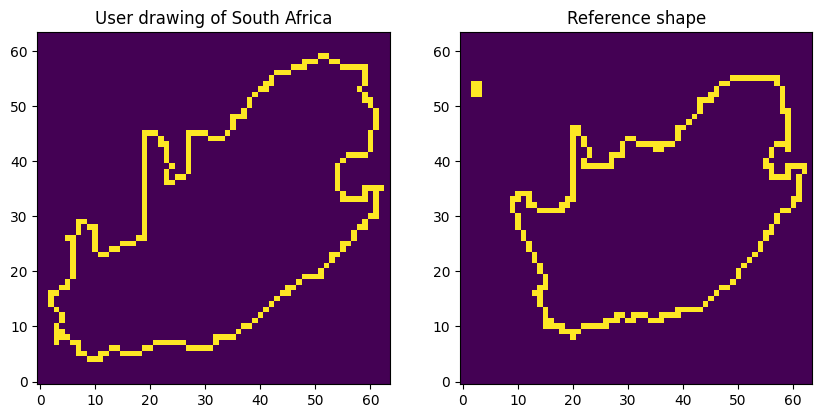

In [63]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [2]:
device = torch.device("mps")

In [26]:
mlflow.set_experiment("random_params")

params = {"channels": 4*random.randint(1, 6),
          "nr_conv_blocks": random.randint(2, 5),
          "embedding_size": 32*random.randint(2, 7),
          "shape": 32*random.randint(2, 5),
          "learning_rate": random.uniform(0.006, 0.012), 
          "margin": random.uniform(0.5, 1.5),
          "temperature": random.uniform(0.5, 1),
          "nr_epochs": random.randint(40, 100)}

model = Model(**params).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

In [27]:
#Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

In [28]:
with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    #Start training
    for epoch in range(params['nr_epochs']):
        losses = []        
        model.train()
        for batch in train_dl:
            optimizer.zero_grad()
            anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
            pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
            neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))
    
            #Mine triplets
            anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                       batch["pos_idx"], batch["neg_idx"])
    
            loss = triplet_loss(anc_emb, pos_emb, neg_emb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        mlflow.log_metric("loss", np.mean(losses), epoch)
        
        print('Epoch: {}/{}\t loss: {:.3f}'.format(epoch+1, params['nr_epochs'], np.mean(losses)))
    
        if (epoch+1)%5==0:
            ranking = np.array([])
            model.eval()
            model.load_reference(ref_data)
            for batch in val_dl:
                rank = eval_fn(model, batch)
                ranking = np.append(ranking, rank)
    
            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)
    
            print('Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
                  .format(epoch+1, params['nr_epochs'], np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

Epoch: 1/86	 loss: 0.200
Epoch: 2/86	 loss: 0.420
Epoch: 3/86	 loss: 0.187
Epoch: 4/86	 loss: 0.205
Epoch: 5/86	 loss: 0.370
Epoch: 5/86	 Average rank: 14.29	 top 10 acc: 73.6%	 top 1 acc: 40.1%	
Epoch: 6/86	 loss: 0.129
Epoch: 7/86	 loss: 0.221
Epoch: 8/86	 loss: 0.197
Epoch: 9/86	 loss: 0.176
Epoch: 10/86	 loss: 0.160
Epoch: 10/86	 Average rank: 12.81	 top 10 acc: 74.1%	 top 1 acc: 39.1%	
Epoch: 11/86	 loss: 0.131
Epoch: 12/86	 loss: 0.204
Epoch: 13/86	 loss: 0.193
Epoch: 14/86	 loss: 0.206
Epoch: 15/86	 loss: 0.263
Epoch: 15/86	 Average rank: 11.42	 top 10 acc: 73.1%	 top 1 acc: 35.5%	
Epoch: 16/86	 loss: 0.126
Epoch: 17/86	 loss: 0.159
Epoch: 18/86	 loss: 0.108
Epoch: 19/86	 loss: 0.183
Epoch: 20/86	 loss: 0.192
Epoch: 20/86	 Average rank: 12.53	 top 10 acc: 73.6%	 top 1 acc: 40.1%	
Epoch: 21/86	 loss: 0.106
Epoch: 22/86	 loss: 0.112
Epoch: 23/86	 loss: 0.070
Epoch: 24/86	 loss: 0.136
Epoch: 25/86	 loss: 0.096
Epoch: 25/86	 Average rank: 9.42	 top 10 acc: 73.1%	 top 1 acc: 39.1%	
E

### Evaluate model

In [29]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [30]:
ranking = np.array([])
model.load_reference(ref_data)
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [31]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 2.55	 top 10 acc: 93.5%	 top 1 acc: 61.3%	


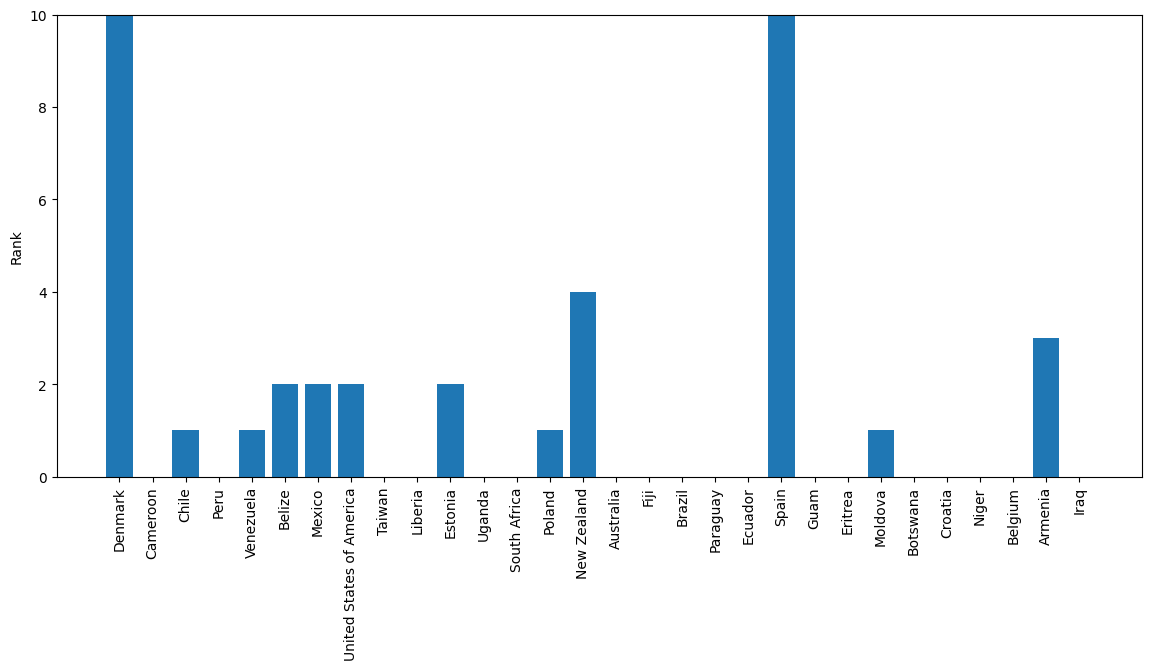

In [32]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [11]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

## Register model
Compare models and push to producton

In [108]:
#For now use the UI

In [138]:
best_run = mlflow.search_runs(order_by=["metrics.test_avg_rank ASC"]).iloc[0]
mlflow.register_model(f"runs:/{best_run.run_id}/model", "Model")

Registered model 'Model' already exists. Creating a new version of this model...
Created version '2' of model 'Model'.


<ModelVersion: aliases=[], creation_timestamp=1714761765025, current_stage='None', description=None, last_updated_timestamp=1714761765025, name='Model', run_id='e6e9ca159b304b7ab1224f65240f6d5b', run_link=None, source='file:///Users/jortdejong/GitHub/country-guess/mlruns/0/e6e9ca159b304b7ab1224f65240f6d5b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>